Edge Filter
======
We show that a network can learn a simple edge filter with a single convolution


In [1]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip3 install https://download.pytorch.org/whl/{accelerator}/torch-1.1.0-{platform}-linux_x86_64.whl
    !pip3 install https://download.pytorch.org/whl/{accelerator}/torchvision-0.3.0-{platform}-linux_x86_64.whl

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

Parameter Settings
-------------------


In [2]:
num_epochs = 10
batch_size = 512
learning_rate = 1e-1
use_gpu = True

CIFAR Data Loading
-------------------

The CIFAR dataset contains 60000 32x32 colour images, split into 50000 training images and 10000 test images. Each image is labeled as one of either 10 (CIFAR10) or 100 (CIFAR100) classes, but we are not using the labels here.

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10

gt_edge_filter = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
gt_edge_filter.weight.data = torch.FloatTensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]]).view(1, 1, 3, 3)

def edge_filter(img):
    with torch.no_grad():
        return gt_edge_filter(img.unsqueeze(0)).squeeze(0)

class EdgeImageDataset(Dataset):
    
    def __init__(self, root, train=True):
        self.cifar = CIFAR10(root=root, train=train, transform=None, target_transform=None, download=True)
        
        self.img_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor()
        ])
        
        self.img2edge_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Lambda(edge_filter)
        ])
    
    def __getitem__(self, index):
        img = self.cifar[index][0]
        return (self.img_transform(img), self.img2edge_transform(img))
        
    def __len__(self):
        return len(self.cifar)

train_dataset = EdgeImageDataset('./data/CIFAR10', train=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = EdgeImageDataset('./data/CIFAR10', train=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Edge Filter Definition
-----------------------

In [4]:
class EdgeNet(nn.Module):
    def __init__(self, d=128):
        super(EdgeNet, self).__init__()
        
        # we are not using bias in this convolution, so that the learned kernel
        # can be compared with the ground truth edge kernel
        self.conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)

    def forward(self, input):
        return self.conv(input)

enet = EdgeNet()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
enet = enet.to(device)

num_params = sum(p.numel() for p in enet.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

Number of parameters: 9


Train Edge Filter
--------


In [5]:
optimizer = torch.optim.Adam(params=enet.parameters(), lr=learning_rate)

# set to training mode
enet.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, edge_batch in train_dataloader:
        
        image_batch = image_batch.to(device)
        edge_batch = edge_batch.to(device)
        
        # predict edges given the image
        predicted_edge_batch = enet(image_batch)
        
        # loss is the L2 error to the actual edges
        loss = F.mse_loss(predicted_edge_batch, edge_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 10] average loss: 0.031936
Epoch [2 / 10] average loss: 0.000593
Epoch [3 / 10] average loss: 0.000047
Epoch [4 / 10] average loss: 0.000002
Epoch [5 / 10] average loss: 0.000236
Epoch [6 / 10] average loss: 0.000001
Epoch [7 / 10] average loss: 0.000247
Epoch [8 / 10] average loss: 0.000000
Epoch [9 / 10] average loss: 0.000345
Epoch [10 / 10] average loss: 0.000000


Plot Training Curves
--------------------

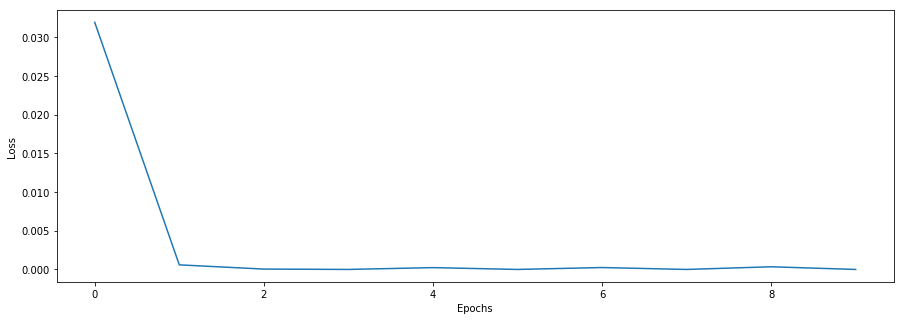

In [6]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(15, 5))
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Alternatively: Load Pre-Trained Color Regressor
-----------------------------

In [7]:
filename = 'edge_net.pth'
import urllib
if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/"+filename, "./pretrained/"+filename)
enet.load_state_dict(torch.load('./pretrained/'+filename))
print('done')

# this is how the model parameters can be saved:
# torch.save(enet.state_dict(), './pretrained/my_edge_net.pth')

Evaluate on the Test Set
----------------------------

In [8]:
# set to evaluation mode
enet.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, edge_batch in train_dataloader:

    with torch.no_grad():
   
        image_batch = image_batch.to(device)
        edge_batch = edge_batch.to(device)

        # predict edges given the image
        predicted_edge_batch = enet(image_batch)

        # loss is the L2 error to the actual edges
        loss = F.mse_loss(predicted_edge_batch, edge_batch)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))

average loss: 0.000000


Show Random Edge Images from the Test Set
-------------------------------------------------


learned edge filter
[[[[ 1.0000099e+00 -9.1140173e-06 -9.9999076e-01]
   [ 1.9999903e+00  2.7188278e-05 -2.0000093e+00]
   [ 1.0000100e+00 -9.2017199e-06 -9.9999034e-01]]]]
ground truth edge filter
[[[[ 1.  0. -1.]
   [ 2.  0. -2.]
   [ 1.  0. -1.]]]]


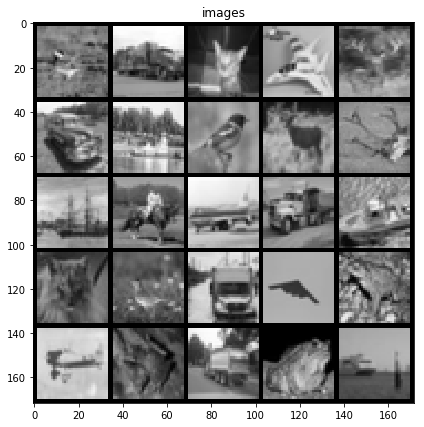

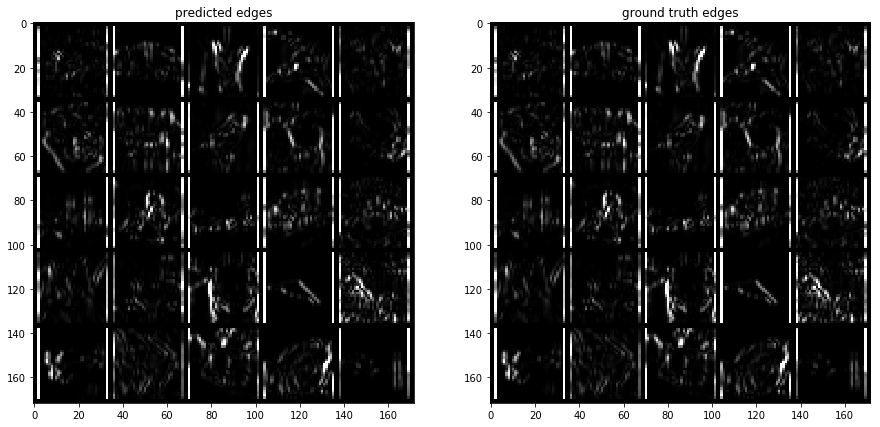

In [9]:
import numpy as np
from skimage import color, io

import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

with torch.no_grad():

    # pick a random subset of images from the test set
    image_inds = np.random.choice(len(test_dataset), 25, replace=False)
    image_batch = torch.stack([test_dataset[i][0] for i in image_inds])
    edge_batch = torch.stack([test_dataset[i][1] for i in image_inds])
    image_batch = image_batch.to(device)

    # predict edges
    predicted_edge_batch = enet(image_batch)

    image_batch.cpu()
    predicted_edge_batch.cpu()

    # get edge magnitudes in [0,1]
    predicted_edge_batch = ((predicted_edge_batch/4.0).pow(2)*4.0).clamp(min=0, max=1)
    edge_batch = ((edge_batch/4.0).pow(2)*4.0).clamp(min=0, max=1)

    print('learned edge filter')
    print(enet.conv.weight.cpu().detach().numpy())

    print('ground truth edge filter')
    print(gt_edge_filter.weight.cpu().detach().numpy())

    # plot images
    fig, ax = plt.subplots(figsize=(7, 7), nrows=1, ncols=1)
    ax.imshow(np.transpose(torchvision.utils.make_grid(image_batch, nrow=5).cpu().numpy(), (1, 2, 0)))
    ax.title.set_text('images')

    # plot edges
    fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(predicted_edge_batch, nrow=5).cpu().numpy(), (1, 2, 0)))
    ax[0].title.set_text('predicted edges')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(edge_batch, nrow=5).cpu().numpy(), (1, 2, 0)))
    ax[1].title.set_text('ground truth edges')
    plt.show()
